In [1]:
filename_weather = "Am_Timan_chad.csv"
#filename_green = "ukr-ndvi-adm2-full.csv"
filename_green = "Chad_green.csv"
#start = 2006
#end = 2021

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

class WeatherModel():
    def __init__(self, filename, start_year=2003, end_year=2024):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'SLP', 'STP', "FRSHTT"])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[(self.data['DATE'].dt.year >= start_year) & (self.data['DATE'].dt.year <= end_year)]
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.ffill()
        print("ISNA here")
        print(self.data.isna().sum())

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "DEWP", "WDSP"]]
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, train_stop = None):

        if train_stop is None:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals.shape[1])

            for i in range(self.residuals.shape[1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model.fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None
        else:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals[:,train_stop].shape[1])

            for i in range(self.residuals.shape[:,train_stop][1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model[:,train_stop].fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    # def fit(self, p,q, train_stop = None):
    #     self.fit_arma(order = (p,0,q), train_stop)
        # return None

    # def Grid(self):
    #     dict_for_GS = dict()
    #     dict_for_GS[p0] = [0,1,2,3,4,5,6,7]
    #     dict_for_GS[q0] = [0,1,2,3,4,5,6,7]
    #     GS = GridSearchCV(wm.fit, dict_for_GS, n_jobs = -1)
    #     GS.f=best_score
    #     wm.fit(1,0,1)
    #     models = wm.arma_models
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



In [3]:
wm = WeatherModel(filename_weather)

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

# dict_for_GS = dict()
# dict_for_GS["p0"] = [0,1,2,3,4,5,6,7]
# dict_for_GS["q0"] = [0,1,2,3,4,5,6,7]
# GS = GridSearchCV(wm, dict_for_GS, n_jobs = -1, scoring = score)
# GS.fit(wm.data)
# #GS.f = best_score
# models = wm.arma_models

#Making values to look over
wm = WeatherModel(filename_weather)



wm.fit(order=(1, 0, 1))

ISNA here
STATION    0
DATE       0
DEWP       0
MAX        0
MIN        0
MXSPD      0
PRCP       0
TEMP       0
VISIB      0
WDSP       0
dtype: int64
ISNA here
STATION    0
DATE       0
DEWP       0
MAX        0
MIN        0
MXSPD      0
PRCP       0
TEMP       0
VISIB      0
WDSP       0
dtype: int64


Fitting 5/7 ARMA models:  71%|███████▏  | 5/7 [00:02<00:00,  2.19it/s]/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Fitting 7/7 ARMA models: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


In [4]:
predictions = wm.predict(start=0, future=365*10)

Seasonal Predictions (11315, 7)
Residual shape (7, 11316)
Num stacks 31
Num extras 1


(7, 11316)
(7, 7665)


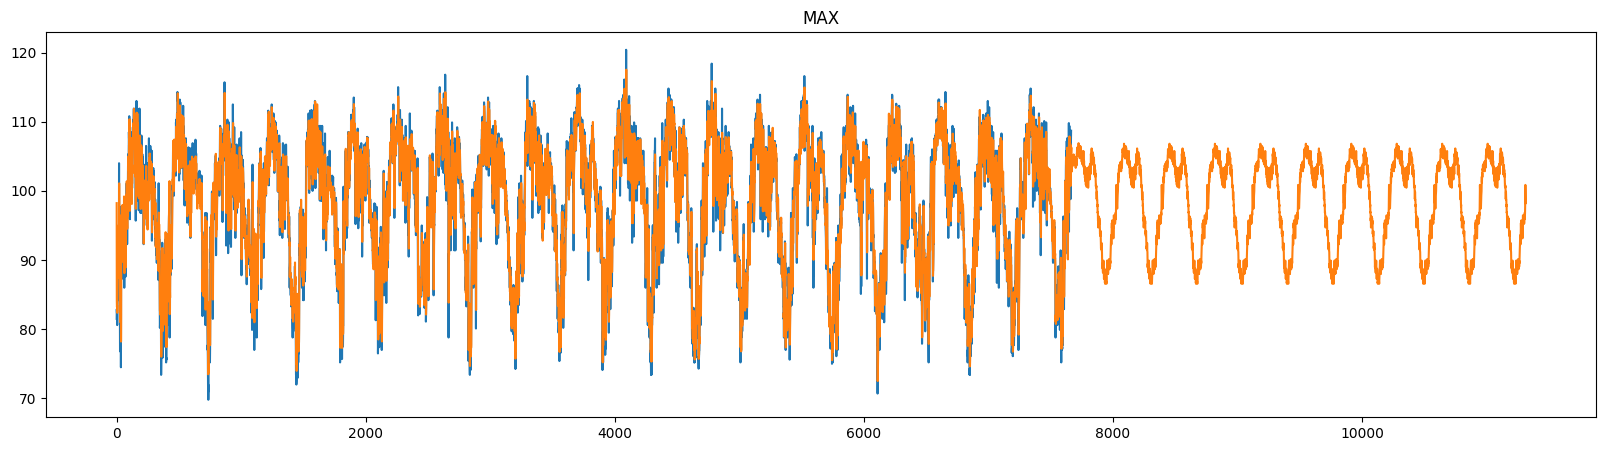

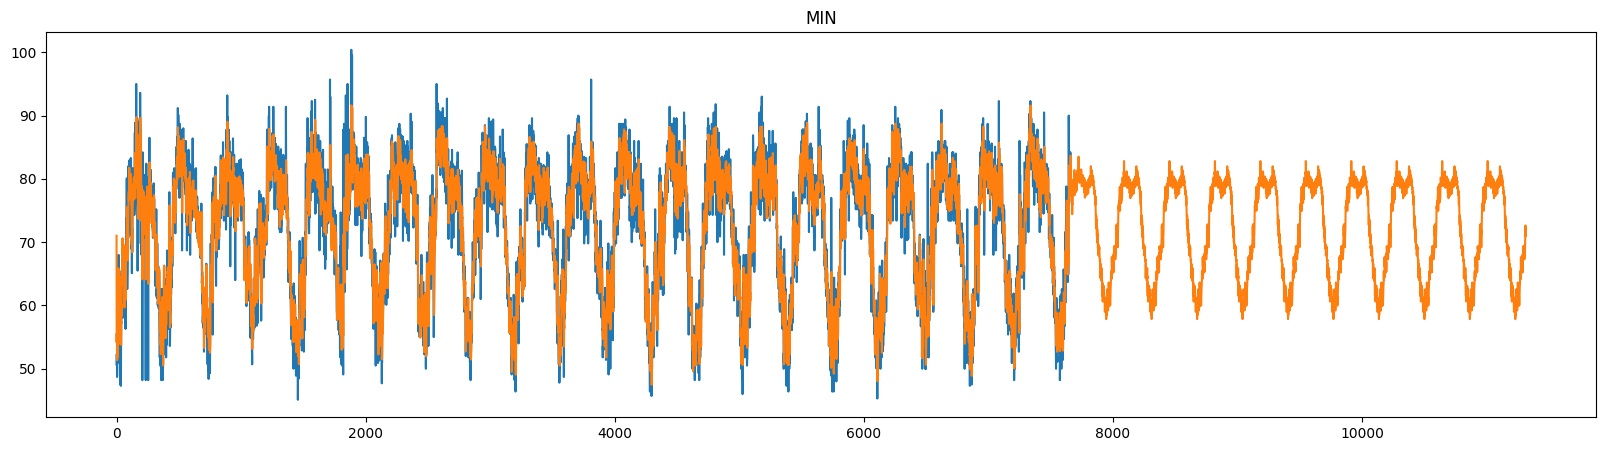

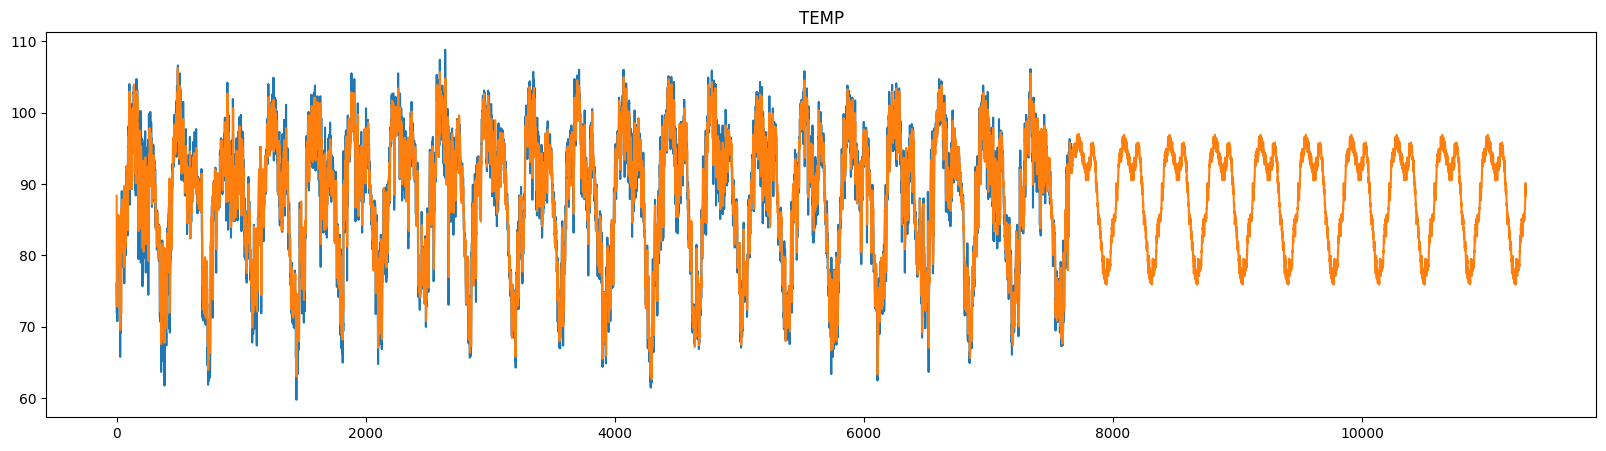

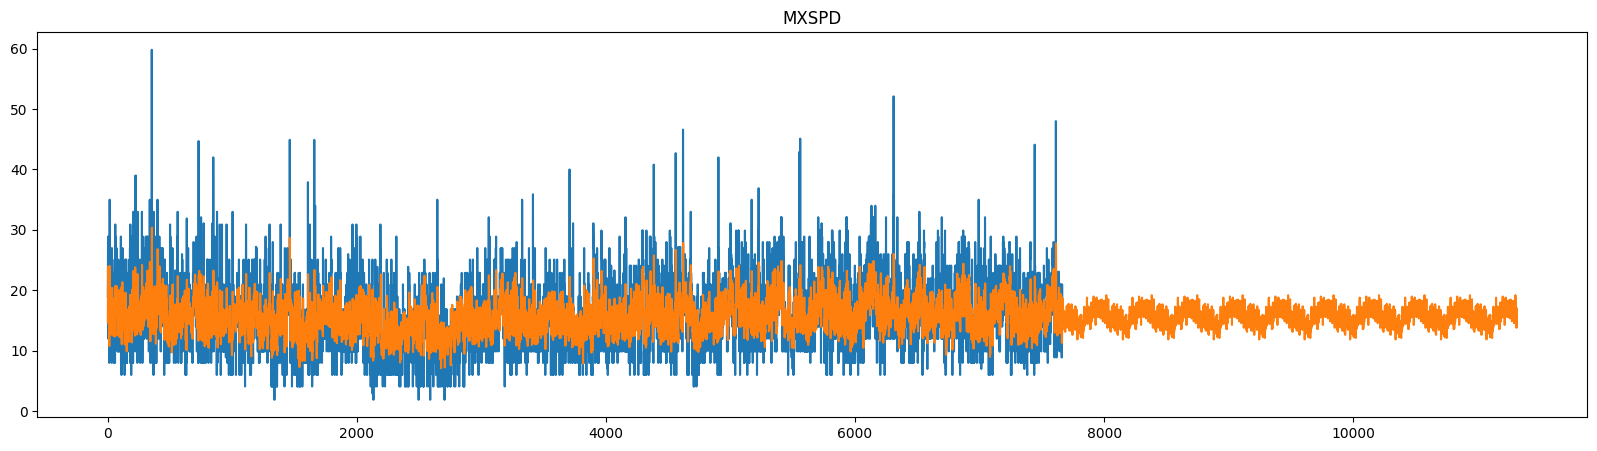

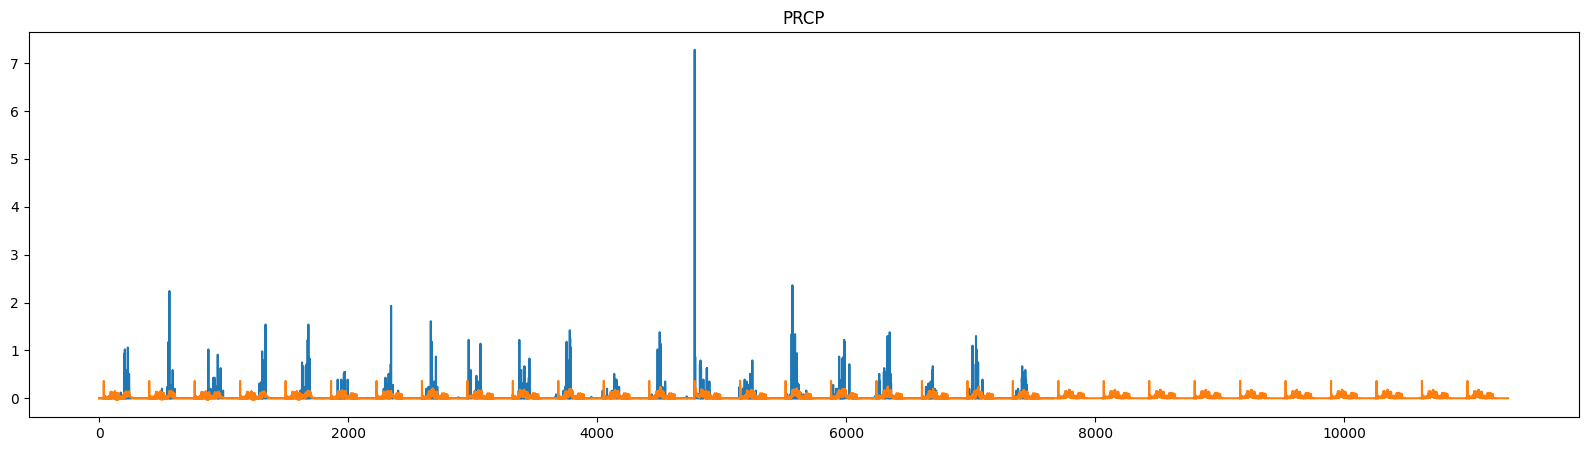

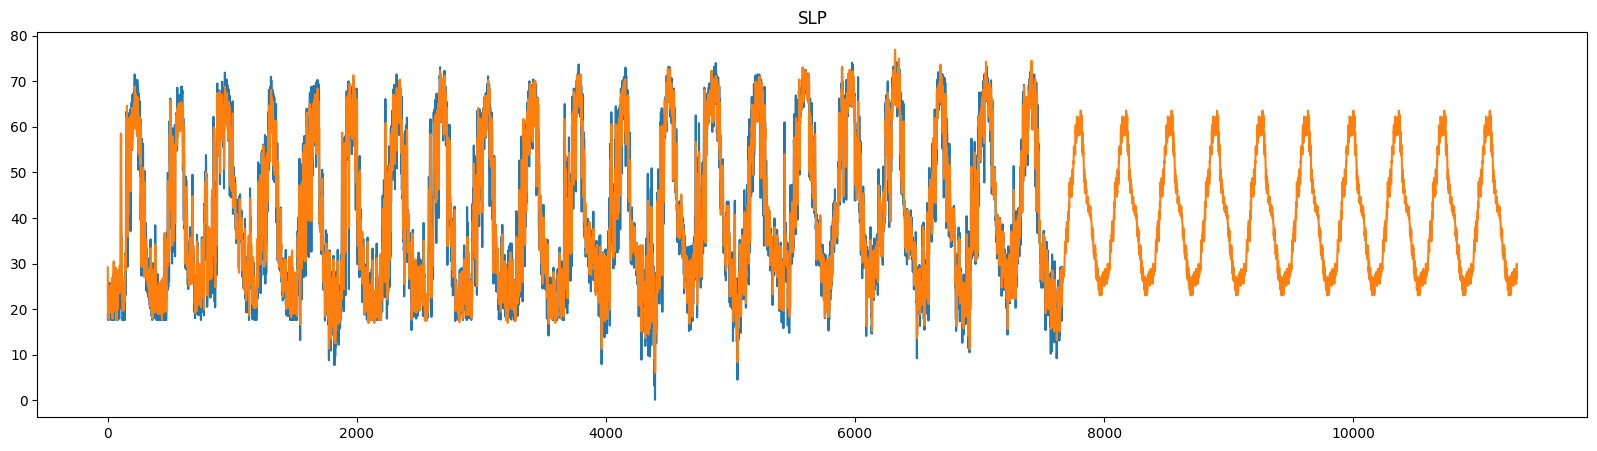

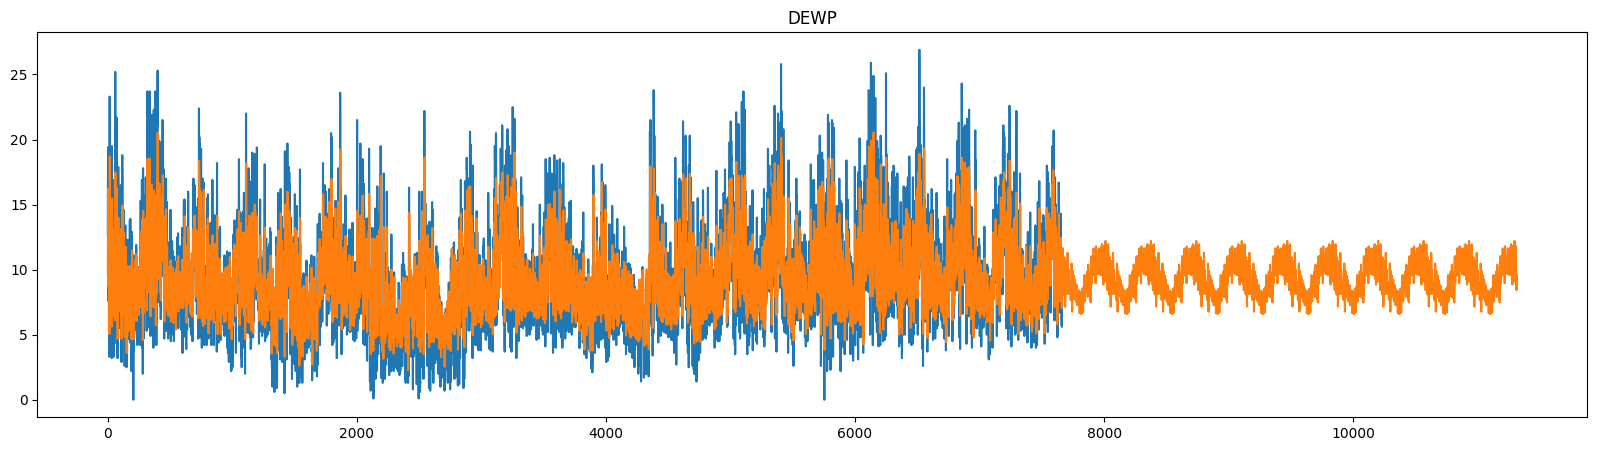

In [5]:
print(predictions.shape)

unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
print(unrolled_data.shape)
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


MAX      0
MIN      0
TEMP     0
MXSPD    0
PRCP     0
DEWP     0
WDSP     0
dtype: int64
(228,)
green (228,)
#date
2003-01-31    0.270233
2003-02-28    0.244300
2003-03-31    0.227767
2003-04-30    0.230533
2003-05-31    0.269500
Freq: M, Name: residuals, dtype: float64 #date
2021-08-31    0.749567
2021-09-30    0.706000
2021-10-31    0.617600
2021-11-30    0.493233
2021-12-31    0.380300
Freq: M, Name: residuals, dtype: float64
##################################
                   MAX        MIN       TEMP      MXSPD      PRCP       DEWP  \
DATE                                                                           
2003-01-31   87.145161  56.600000  77.193548  17.387097  0.000000  19.548387   
2003-02-28   91.610714  62.128571  81.850000  15.532143  0.000000  20.439286   
2003-03-31   94.277419  65.625806  85.303226  18.738710  0.000000  21.093548   
2003-04-30  104.903333  77.370000  96.903333  16.506667  0.000667  27.963333   
2003-05-31  106.635484  76.696774  98.190323  16.52

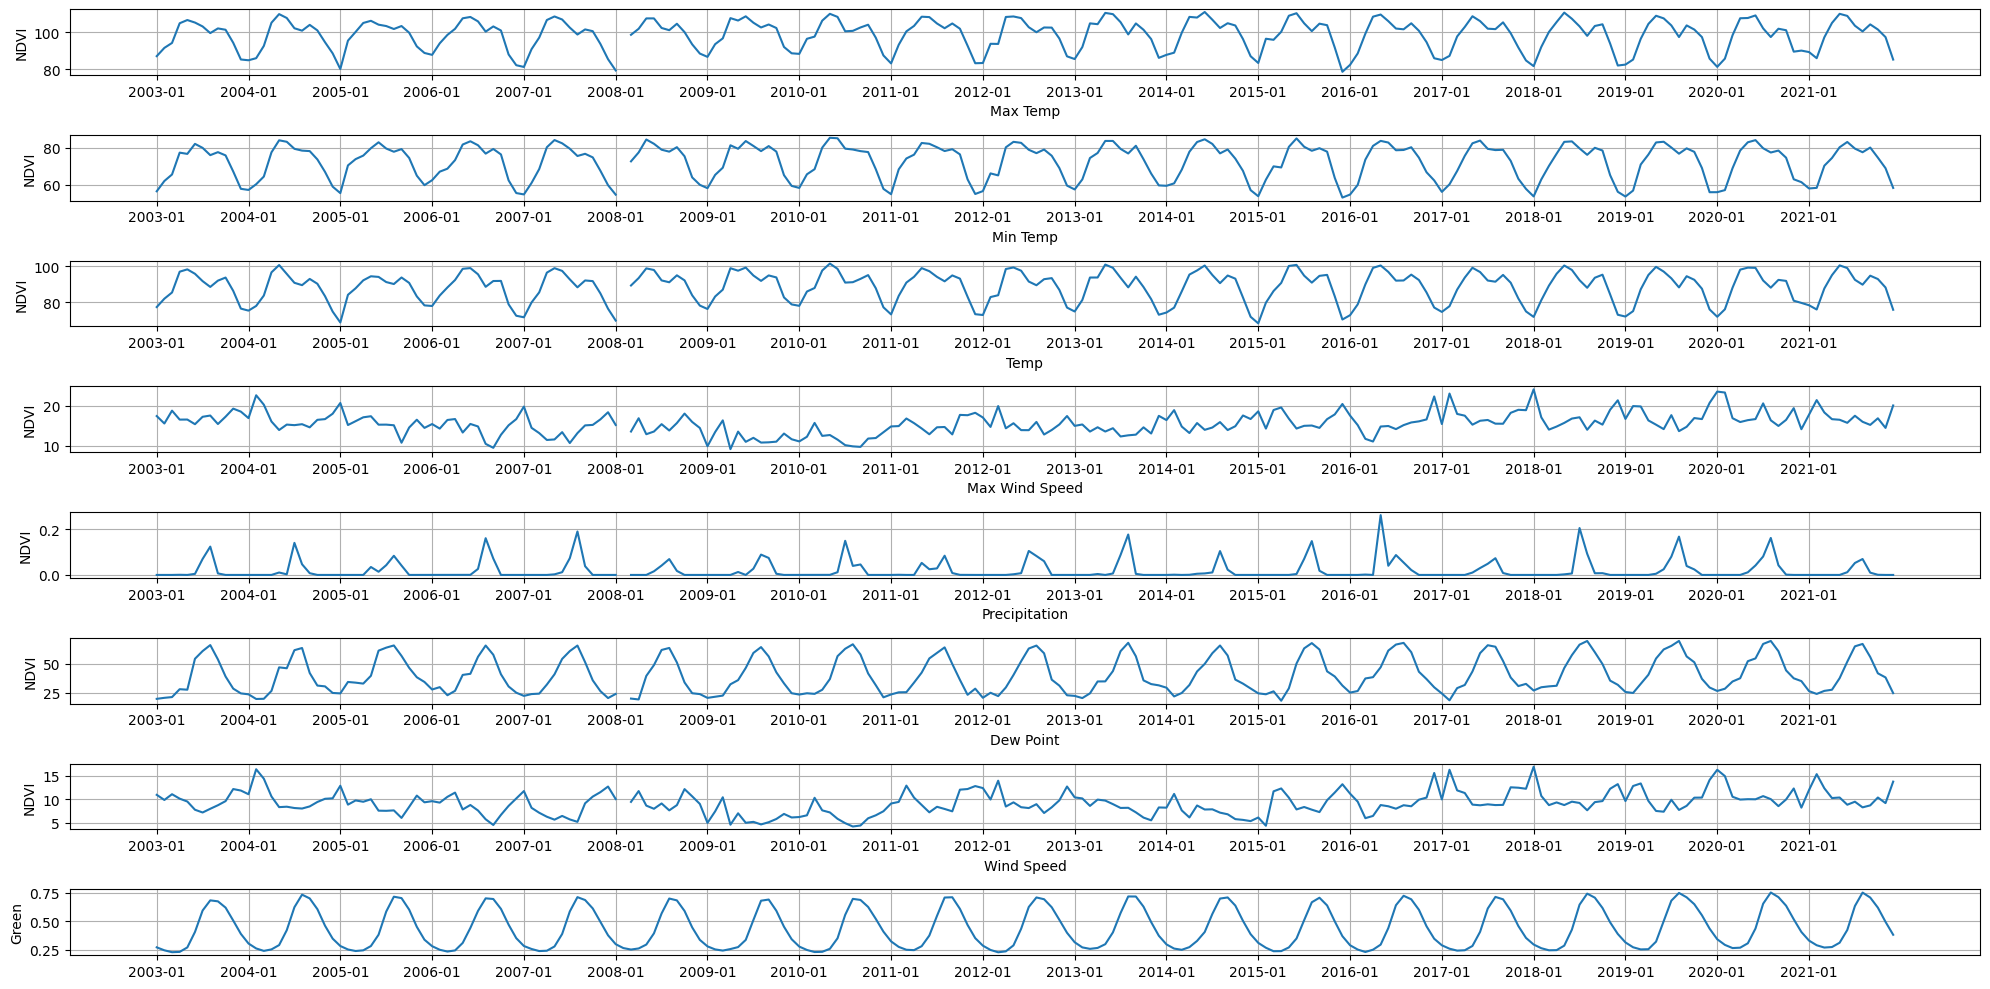

(228,)
(7, 228)


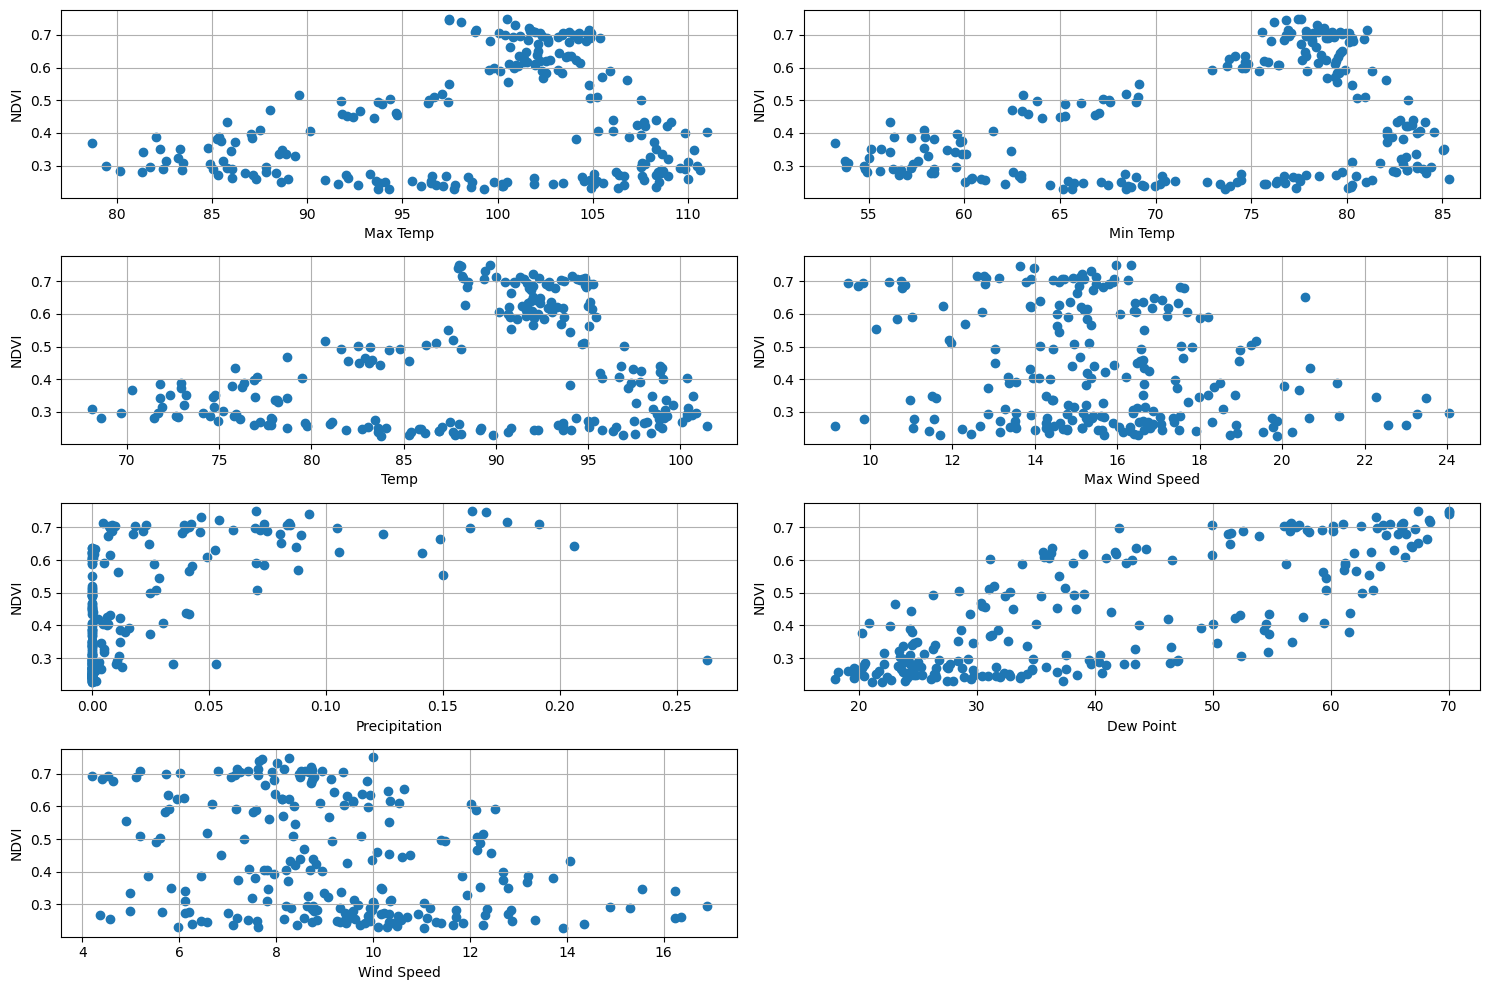

In [6]:
#Plotting the scatter of feature vs food prioce for triend
# unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "DEWP", "WDSP"]
# weather = pd.read_csv('ilocos-sur-weather.csv')
# weather = weather[["DATE"] + feature_names]

# wdata = weather[feature_names].to_numpy()
# wdata -= wm.seasonal
# wdata = wdata.reshape(-1, wdata.shape[2]).T

# wdata = pd.DataFrame(wdata, columns=feature_names)
# weather = weather[["DATE"] + feature_names]


# weather = weather.set_index("DATE")
# weather = weather.resample('ME').max()

weather = pd.DataFrame(wm.data[feature_names], columns=feature_names)
print(weather.isna().sum())
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather["DATE"] = wm.data["DATE"]
weather = weather[(weather["DATE"].dt.year >= 2003) & (weather["DATE"].dt.year < 2022)]
weather = weather.set_index("DATE")
weather = weather.resample('M').mean()

green = pd.read_csv(filename_green)#, skiprows=1)#, ignore_row=1)
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year < 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('M').mean()
print(green.shape)

print("green", green.shape)

print(green.head(), green.tail())
print("##################################")
print(weather.head(), weather.tail())

y = green.values
weather = weather.to_numpy().T
print(weather.shape)
print(wm.seasonal.shape)

plt.figure(figsize=(20, 10))

feature_names2 = ["Max Temp", "Min Temp", "Temp", "Max Wind Speed", "Precipitation",  "Dew Point", "Wind Speed"]
for i in range(len(weather)):
    plt.subplot(len(weather)+1, 1, i+1)
    plt.plot(weather[i])
    plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
    plt.xlabel(feature_names2[i])
    plt.ylabel("NDVI")
    plt.grid()


plt.subplot(len(weather)+1, 1, len(weather)+1)
plt.plot(y)
plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
plt.ylabel("Green")
plt.grid()
plt.tight_layout()

plt.show()

print(y.shape)
print(weather.shape)
plt.figure(figsize=(15, 10))
for i in range(len(weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(weather[i], y)
    plt.xlabel(feature_names2[i])
    plt.ylabel("NDVI")
    plt.grid()
plt.tight_layout()
plt.savefig("Scatter_Ukraine.pdf", dpi=300, bbox_inches="tight")

plt.show()




In [7]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

class GreenModel():
    def __init__(self, lmda=0.1):
        self.theta = None
        self.shift = None
        self.scale = None
        self.bias = None
        self.lmda = lmda

    def fit(self, X, y):
        # Can use smoothing here
        basis_funcs = []
        xs = np.arange(X.shape[1])
        
        shift0 = np.zeros(X.shape[0])
        scale0 = np.ones(X.shape[0])
        bias0 = 0
        theta0 = np.concatenate([shift0, scale0, [bias0]])

        def f(theta):
            shift = theta[:X.shape[0]]
            scale = theta[X.shape[0]:-1]
            bias = theta[-1]

            predictions = np.zeros(X.shape[1]) 
            for i in range(X.shape[0]):
                func = CubicSpline(xs, X[i])
                predictions += func(xs-shift[i]) * scale[i]
            predictions += bias

            return np.mean((predictions - y)**2) + self.lmda * np.sum(np.abs(theta))
        
        res = minimize(f, theta0, method="Nelder-Mead")
        self.theta = res.x
        self.shift = self.theta[:X.shape[0]]
        self.scale = self.theta[X.shape[0]:-1]
        self.bias = self.theta[-1]
        self.basis_funcs = basis_funcs
        return res

    def predict(self, X):
        print(X.shape)
        predictions = np.zeros(X.shape[1])
        xs = np.arange(X.shape[1])
        for i in range(X.shape[0]):
            func = CubicSpline(xs, X[i])
            predictions += func(xs - self.shift[i]) * self.scale[i] 

        predictions += self.bias
        return predictions


In [8]:
gm = GreenModel(lmda=0)
features = weather[[0, 1, 2, 4, 6]]
train_features = features[:, :151]
test_features = features[:, 151:]
train_features = np.array([np.delete(train_features[i], 61) for i in range(len(train_features))])
y = np.delete(y, 61)
print(np.shape(y))
print(np.shape(train_features))
gm.fit(train_features, y[:150])

(227,)
(5, 150)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.017561990500314553
             x: [ 1.589e-02  7.817e-03 -5.038e-03 -1.061e-02  2.320e-02
                  1.095e-02  1.068e-02 -1.650e-02  1.978e+00 -1.786e-03
                  3.050e-03]
           nit: 855
          nfev: 1272
 final_simplex: (array([[ 1.589e-02,  7.817e-03, ..., -1.786e-03,
                         3.050e-03],
                       [ 1.589e-02,  7.816e-03, ..., -1.804e-03,
                         3.050e-03],
                       ...,
                       [ 1.589e-02,  7.817e-03, ..., -1.758e-03,
                         3.050e-03],
                       [ 1.589e-02,  7.817e-03, ..., -1.827e-03,
                         3.050e-03]]), array([ 1.756e-02,  1.756e-02,  1.756e-02,  1.756e-02,
                        1.756e-02,  1.756e-02,  1.756e-02,  1.756e-02,
                        1.756e-02,  1.756e-02,  1.756e-02,  1.756e-02]))

(5, 77)
77
77


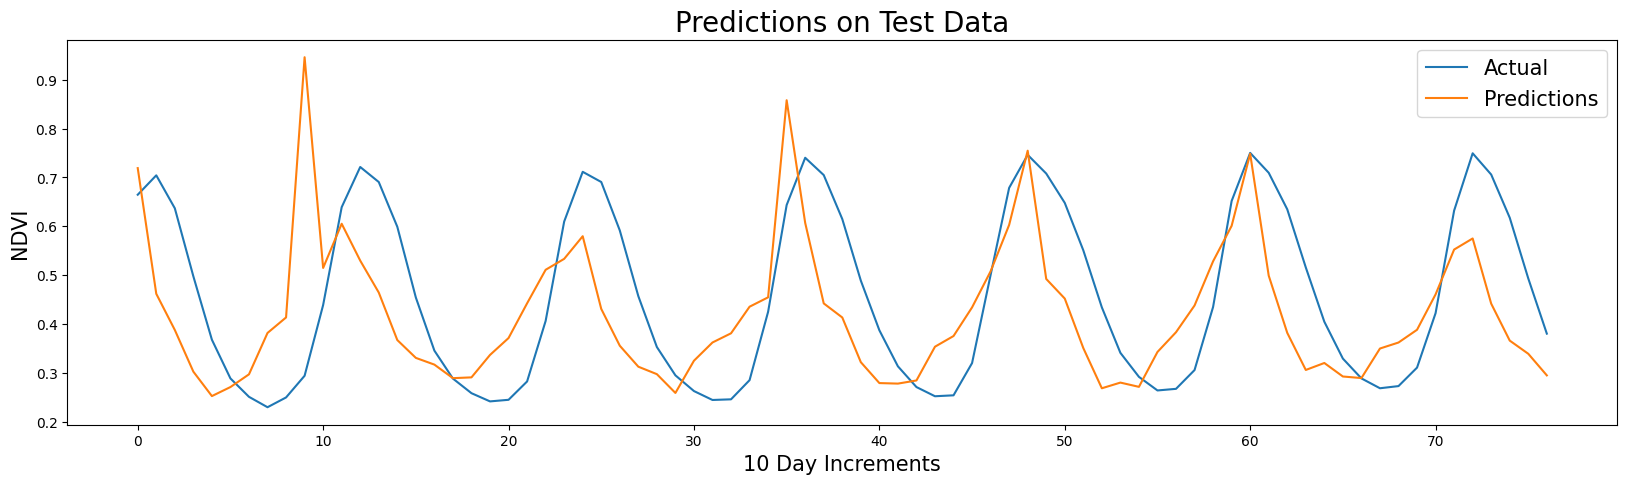

In [10]:
prediction = gm.predict(test_features)
plt.figure(figsize=(20, 5))
num = 150 + len(test_features)
print(len(prediction))
print(len(y[150:]))
plt.plot(np.arange(len(prediction)), y[150:], label = "Actual")
plt.plot(np.arange(len(prediction)), prediction, label = "Predictions")
plt.title("Predictions on Test Data",fontsize=20)
plt.ylabel("NDVI", fontsize=15)
plt.xlabel("10 Day Increments", fontsize=15)
plt.legend(fontsize=15)
plt.savefig("TestPredict_Ukraine.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y[150:], prediction))

0.0040750093367756994


In [ ]:
plt.figure(figsize=(20, 5))
t = np.linspace(0, 200, 100)
plt.plot(t, gm.basis_funcs[0](t))
plt.show()

IndexError: list index out of range

<Figure size 2000x500 with 0 Axes>

In [11]:
print(gm.shift)
print(gm.scale)

[ 0.01588894  0.00781693 -0.00503843 -0.0106123   0.02320139]
[ 1.09516834e-02  1.06815022e-02 -1.64998758e-02  1.97801604e+00
 -1.78614614e-03]


## Predicting the far future

In [47]:
#2060 predictions
Max_Temp_mean = np.abs(np.array([29.94,31.58,36.98,39.36,41.59,39.61,36.76,36.12,37.52,37.94,33.41,30.54]))
precip_mean = np.abs(np.array([0,0,1.09,7.34,16.53,30.91,87.9,216.29,54.2,20.59,1.16,0]))
Max_temp_var = np.abs(np.array([-0.880656583,-1.164200678,0.3139066719725058,0.23726706165128128,-0.093284392,0.033468859,-1.065807331,-0.05397675,0.5046206057692894,0.7612400014756832,-0.2017563,-0.953739065]))
#From march on, excluding december
Precip_var = np.abs(np.array([0,0,0.7315614792408563,0.17033518232639208,-0.301308229,-0.663324287,-0.440303671,2.432430800861078,-0.410200893,0.6471079458773514,0.37843930394953457,0.5920602546731717,0]))
month_lengths = [31,29,31,30,31,30,31,31,30,31,30,31]

Max_temp_pred = []
Precip_pred = []
for i in range(12):
    Max_temp_pred.append(np.random.normal(Max_Temp_mean[i],Max_temp_var[i], size = month_lengths[i]).tolist())
    if i in [0,1,11]: 
        Precip_pred.append(np.zeros(month_lengths[i]).tolist())
    else:
        Precip_pred.append((np.random.normal(precip_mean[i],Precip_var[i], size = month_lengths[i])/month_lengths[i]).tolist())
#Got code for this list merging from Google AI feature
future_temp = np.array([item for month in Max_temp_pred for item in month])[::30]
future_temp = future_temp* (9/5) + 32
future_precip = np.array([item for month in Precip_pred for item in month])[::30]
future_precip = future_precip*0.0393701
future_pred = np.array([future_temp,future_precip])


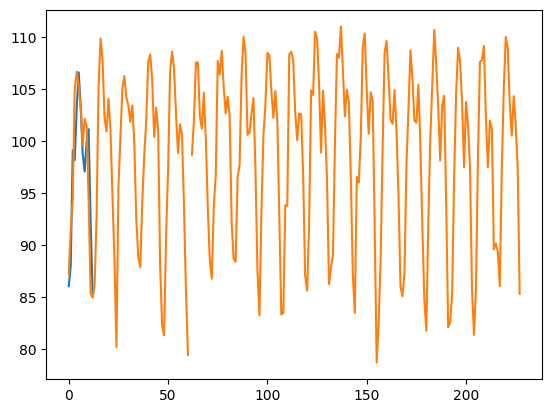

In [48]:
plt.plot(future_temp)
plt.plot(weather[0])

In [38]:
gm = GreenModel(lmda=0)
features = weather[[0, 4]]
train_features = features[:, :151]
test_features = features[:, 151:]
train_features = np.array([np.delete(train_features[i], 61) for i in range(len(train_features))])
y = np.delete(y, 61)
print(np.shape(y))
print(np.shape(train_features))
gm.fit(train_features, y[:150])

(220,)
(2, 150)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.034532532390093254
             x: [ 1.938e-03  8.545e-04  4.008e-03  9.878e-01  1.398e-03]
           nit: 73
          nfev: 138
 final_simplex: (array([[ 1.938e-03,  8.545e-04, ...,  9.878e-01,
                         1.398e-03],
                       [ 1.938e-03,  8.546e-04, ...,  9.877e-01,
                         1.398e-03],
                       ...,
                       [ 1.938e-03,  8.544e-04, ...,  9.878e-01,
                         1.397e-03],
                       [ 1.939e-03,  8.551e-04, ...,  9.878e-01,
                         1.398e-03]]), array([ 3.453e-02,  3.454e-02,  3.455e-02,  3.455e-02,
                        3.456e-02,  3.457e-02]))

(2, 37)
37
70


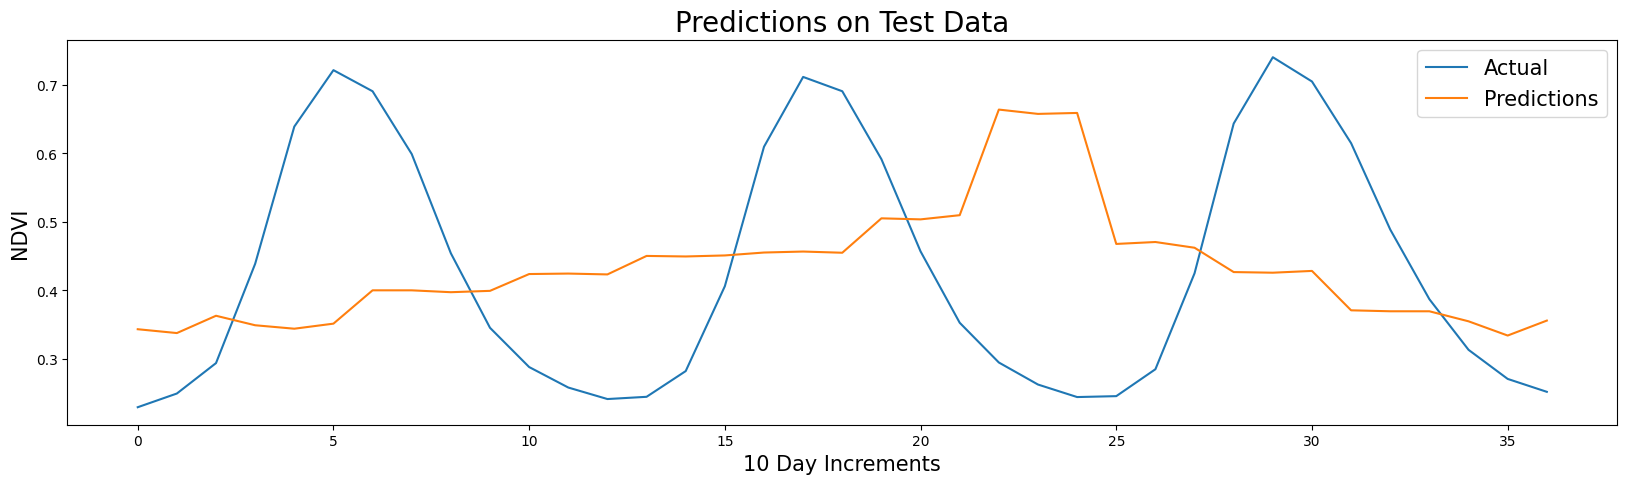

In [39]:
prediction = gm.predict(future_pred)
plt.figure(figsize=(20, 5))
num = 150 + len(test_features)
print(len(prediction))
print(len(y[150:]))
plt.plot(np.arange(len(prediction)), y[150:187], label = "Actual")
plt.plot(np.arange(len(prediction)), prediction, label = "Predictions")
plt.title("Predictions on Test Data",fontsize=20)
plt.ylabel("NDVI", fontsize=15)
plt.xlabel("10 Day Increments", fontsize=15)
plt.legend(fontsize=15)
plt.savefig("TestPredict_Ukraine.pdf", dpi=300, bbox_inches="tight")
plt.show()

(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)
(3, 12)


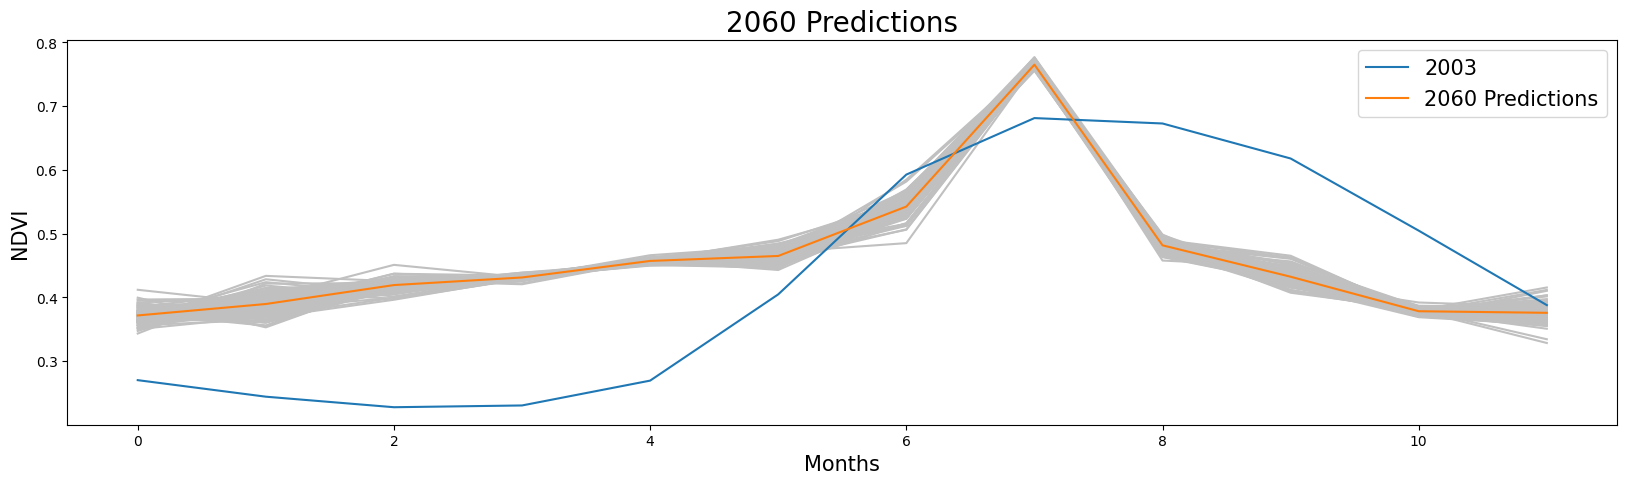

In [86]:
#2060 predictions
Max_Temp_mean = np.array([29.94,31.58,36.98,39.36,41.59,39.61,36.76,36.12,37.52,37.94,33.41,30.54])
min_temp_mean = np.array([15.42,16.48,21.45,25.09,27.58,26.92,25.8,26.73,26.69,25.35,20.38,15.87])
Max_temp_var = np.abs(np.array([-0.880656583,-1.164200678,0.3139066719725058,0.23726706165128128,-0.093284392,0.033468859,-1.065807331,-0.05397675,0.5046206057692894,0.7612400014756832,-0.2017563,-0.953739065]))
#From march on, excluding december
min_temp_var = np.abs(np.array([0.21393614680818138,-0.89036614,-0.844920992,-0.123810157,-0.280527931,-1.079991199,-0.820948341,-0.078829006,0.3949385728434941,0.9665845624950299,-0.318597198,0.10720682962950136]))
month_lengths = [31,29,31,30,31,30,31,31,30,31,30,31]
precip_mean = np.abs(np.array([0,0,1.09,7.34,16.53,30.91,87.9,216.29,54.2,20.59,1.16,0]))
#From march on, excluding december
Precip_var = np.abs(np.array([0,0,0.7315614792408563,0.17033518232639208,-0.301308229,-0.663324287,-0.440303671,2.432430800861078,-0.410200893,0.6471079458773514,0.37843930394953457,0.5920602546731717,0]))
Precip_pred = []
Max_temp_pred = []
min_pred = []
for i in range(12):
    Max_temp_pred.append(np.random.normal(Max_Temp_mean[i],Max_temp_var[i], size = 1).tolist())
    min_pred.append(np.random.normal(min_temp_mean[i],min_temp_var[i], size = 1).tolist())
    if i in [0,1,11]: 
        Precip_pred.append([0])
    else:
        Precip_pred.append((np.random.normal(precip_mean[i],Precip_var[i], size = 1)/month_lengths[i]).tolist())
#Got code for this list merging from Google AI feature
future_temp = np.array([item for month in Max_temp_pred for item in month])
future_temp = future_temp* (9/5) + 32
future_min = np.array([item for month in min_pred for item in month])
future_min = future_min* (9/5) + 32
future_precip = np.array([item for month in Precip_pred for item in month])
future_precip = future_precip*0.0393701
future_pred2 = np.array([future_temp,future_min,future_precip])


gm = GreenModel(lmda=0)
features = weather[[0, 1,4]]
train_features = features[:, :151]
test_features = features[:, 151:]
train_features = np.array([np.delete(train_features[i], 61) for i in range(len(train_features))])
y = np.delete(y, 61)

gm.fit(train_features, y[:150])

#Running 100 times and averaging
plt.figure(figsize=(20, 5))
predtotal = np.zeros_like(gm.predict(future_pred2))
iters = 100
for _ in range(iters):
    Max_Temp_mean = np.array([29.94,31.58,36.98,39.36,41.59,39.61,36.76,36.12,37.52,37.94,33.41,30.54])
    min_temp_mean = np.array([15.42,16.48,21.45,25.09,27.58,26.92,25.8,26.73,26.69,25.35,20.38,15.87])
    Max_temp_var = np.abs(np.array([-0.880656583,-1.164200678,0.3139066719725058,0.23726706165128128,-0.093284392,0.033468859,-1.065807331,-0.05397675,0.5046206057692894,0.7612400014756832,-0.2017563,-0.953739065]))
    #From march on, excluding december
    min_temp_var = np.abs(np.array([0.21393614680818138,-0.89036614,-0.844920992,-0.123810157,-0.280527931,-1.079991199,-0.820948341,-0.078829006,0.3949385728434941,0.9665845624950299,-0.318597198,0.10720682962950136]))
    month_lengths = [31,29,31,30,31,30,31,31,30,31,30,31]
    precip_mean = np.abs(np.array([0,0,1.09,7.34,16.53,30.91,87.9,216.29,54.2,20.59,1.16,0]))
    #From march on, excluding december
    Precip_var = np.abs(np.array([0,0,0.7315614792408563,0.17033518232639208,-0.301308229,-0.663324287,-0.440303671,2.432430800861078,-0.410200893,0.6471079458773514,0.37843930394953457,0.5920602546731717,0]))
    Precip_pred = []
    Max_temp_pred = []
    min_pred = []
    for i in range(12):
        Max_temp_pred.append(np.random.normal(Max_Temp_mean[i],Max_temp_var[i], size = 1).tolist())
        min_pred.append(np.random.normal(min_temp_mean[i],min_temp_var[i], size = 1).tolist())
        if i in [0,1,11]: 
            Precip_pred.append([0])
        else:
            Precip_pred.append((np.random.normal(precip_mean[i],Precip_var[i], size = 1)/month_lengths[i]).tolist())
    #Got code for this list merging from Google AI feature
    future_temp = np.array([item for month in Max_temp_pred for item in month])
    future_temp = future_temp* (9/5) + 32
    future_min = np.array([item for month in min_pred for item in month])
    future_min = future_min* (9/5) + 32
    future_precip = np.array([item for month in Precip_pred for item in month])
    future_precip = future_precip*0.0393701
    future_pred2 = np.array([future_temp,future_min,future_precip])
    prediction = gm.predict(future_pred2)
    plt.plot(np.arange(len(prediction)), prediction, alpha = 1, c = "silver")
    predtotal += prediction





plt.plot(np.arange(len(predtotal)), y[:len(predtotal)], label = "2003")
plt.plot(np.arange(len(predtotal)), predtotal/iters, label = "2060 Predictions")
plt.title("2060 Predictions",fontsize=20)
plt.ylabel("NDVI", fontsize=15)
plt.xlabel("Months", fontsize=15)
plt.legend(fontsize=15)
plt.savefig("2060ChadPredict.pdf", dpi=300, bbox_inches="tight")
plt.show()